In [2]:
#Importing the libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os
import torchvision.transforms as transforms
from torchvision import datasets,models
from tqdm import tqdm
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tqdm import tqdm

In [18]:
class IndexedDataset(Dataset):
    def __init__(self, dir_path):
        self.dir_path = dir_path
        
        # Common transforms for both train and test datasets
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize images to match ViT input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
        ])
        
        # Collecting all image filenames
        self.image_filenames = []
        for (dirpath, dirnames, filenames) in os.walk(dir_path):
            self.image_filenames += [os.path.join(dirpath, file) for file in filenames if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Map for labels
        self.labels_map = {"couch": 0, "motorcycle": 1, "cake": 2, "dog": 3, "boat": 4}
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        try:
            image = Image.open(img_name).convert('RGB')
            image = self.transform(image)
            label = self.labels_map[os.path.basename(os.path.dirname(img_name))]
            return image, label
        except Exception as e:
            print(f"Error loading image {img_name}: {str(e)}")
            # Return a placeholder in case of error
            return torch.zeros((3, 224, 224)), -1

In [19]:

class Patch_Embedding(nn.Module):
    def __init__(self, in_channels=3, embedding_size=768, patch_size=16, img_size=224):
        super().__init__()
        # Assuming that the image size is perfectly divisible by patch_size
        self.embedding_size = embedding_size
        self.num_patches = (img_size // patch_size) ** 2  # (h * w) / (patch_size ** 2)
        self.conv = nn.Conv2d(in_channels, embedding_size, patch_size, stride=patch_size)
        self.cls = nn.Parameter(torch.randn((1, embedding_size)))  # The cls token
        self.pos = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_size))  # Position embedding

    def forward(self, x):
        # x is of shape (batch_size, in_channels, height, width)
        batch_size = x.shape[0]

        # Apply the convolutional layer to get the patch embeddings
        y = self.conv(x)  # y is of shape (batch_size, embedding_size, h/patch_size, w/patch_size)

        # Calculate the number of patches based on the height and width after convolution
        num_patches = y.shape[2] * y.shape[3]

        # Flatten the patches
        out = y.view(batch_size, self.embedding_size, num_patches)  # out is of shape (batch_size, embedding_size, num_patches)

        # Permute to get the correct shape
        out = torch.permute(out, (0, 2, 1))  # out is now of shape (batch_size, num_patches, embedding_size)

        # Expand the cls token to match the batch size
        cls_tokens = self.cls.expand(batch_size, -1, -1)  # cls_tokens is of shape (batch_size, 1, embedding_size)

        # Concatenate the cls token with the patch embeddings
        cout = torch.cat((cls_tokens, out), dim=1)  # cout is of shape (batch_size, num_patches + 1, embedding_size)

        # Ensure the positional embeddings match the number of patches + 1
        pos_embeddings = self.pos[:, :cout.shape[1], :]  # Adjust pos to match the shape of cout

        # Add the position embeddings to the patch and cls embeddings
        pcout = cout + pos_embeddings  # pcout is of shape (batch_size, num_patches + 1, embedding_size)

        return pcout




In [20]:


class ClassificationHead(nn.Module):
    def __init__(self, embedding_size=768, num_classes=5):
        super().__init__()
        self.fc = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        # x is of shape (batch_size, num_patches, embedding_size)
        x = x[:, -1, :]  # Taking the output of the last patch (usually the CLS token's output)
        out = self.fc(x)  # Pass through the fully connected layer for classification
        return out


In [21]:
class MultiAttentionhead(nn.Module):
    def __init__(self, embedding_size=768, num_heads=8, p=0.0):
        super().__init__()
        self.embedding_size = embedding_size  # The embedding size of each patch
        self.num_heads = num_heads  # Number of attention heads
        self.QKV = nn.Linear(embedding_size, 3 * embedding_size)  # Linear layer for Q, K, V
        self.fc = nn.Linear(embedding_size, embedding_size)  # Linear layer for the output
        self.drop = nn.Dropout(p)  # Dropout layer

    def forward(self, x):
        # x is of shape (batch_size, num_patches, embedding_size)
        batch_size = x.shape[0]
        num_patches = x.shape[1]

        # Getting the Q, K, V for every patch in all the batches
        QKV1 = self.QKV(x)  # QKV1 is of shape (batch_size, num_patches, 3 * embedding_size)
        QKV2 = QKV1.reshape(batch_size, num_patches, self.num_heads, self.embedding_size // self.num_heads, 3)
        Q, K, V = torch.permute(QKV2, (4, 0, 2, 1, 3))  # Q, K, V are of shape (batch_size, num_heads, num_patches, embedding_size // num_heads)

        # Computing the attention scores
        QKT = torch.einsum('bhid,bhjd->bhij', Q, K)  # QKT is of shape (batch_size, num_heads, num_patches, num_patches)
        attention = F.softmax(QKT, dim=-1) / (self.embedding_size ** 0.5)  # Scaled softmax attention
        attention = self.drop(attention)

        # Updating the values based on the attention
        QKtV = torch.einsum('bhij,bhjd->bhid', attention, V)  # QKtV is of shape (batch_size, num_heads, num_patches, embedding_size // num_heads)
        z = torch.permute(QKtV, (0, 2, 1, 3))  # z is of shape (batch_size, num_patches, num_heads, embedding_size // num_heads)
        Z = z.reshape(batch_size, num_patches, -1)  # Z is of shape (batch_size, num_patches, embedding_size)
        out = self.fc(Z)  # out is of shape (batch_size, num_patches, embedding_size)
        return out

    

In [22]:

class MLP(nn.Module):
    # The MLP block within the transformer
    def __init__(self, embedding_size=768, p=0.0, expansion=4):
        super().__init__()
        self.fc1 = nn.Linear(embedding_size, expansion * embedding_size)
        self.fc2 = nn.Linear(expansion * embedding_size, embedding_size)
        self.gelu = nn.GELU()
        self.drop = nn.Dropout(p)

    def forward(self, x):
        # x is of shape (batch_size, num_patches, embedding_size)
        x = self.gelu(self.fc1(x))
        out = self.fc2(self.drop(x))
        return out


In [23]:
class Transformer(nn.Module):
    # The overall Transformer block
    def __init__(self, embedding_size=768, p=0.0, expansion=4, num_heads=8):
        super().__init__()
        self.ln1 = nn.LayerNorm(embedding_size)
        self.MAH = MultiAttentionhead(embedding_size, num_heads, p)
        self.ln2 = nn.LayerNorm(embedding_size)
        self.mlp = MLP(embedding_size, p, expansion)

    def forward(self, x):
        identity1 = x
        x = self.MAH(self.ln1(x))
        identity2 = x + identity1  # Skip connection
        out = self.mlp(self.ln2(identity2))
        out = out + identity2  # Skip connection
        return out


In [24]:
class ViT(nn.Module):
    def __init__(self, embedding_size=768, p=0.0, expansion=4, num_heads=8, in_channels=3, patch_size=16, img_size=224, depth=12, num_classes=5):
        super().__init__()

        self.embedding = Patch_Embedding(in_channels, embedding_size, patch_size, img_size)

        # A ViT would have multiple (depth) Transformer blocks
        Tlayers = []
        for i in range(depth):
            Tlayers.append(Transformer(embedding_size, p, expansion, num_heads))

        self.Tlayers = nn.Sequential(*Tlayers)

        self.head = ClassificationHead(embedding_size, num_classes)

    def forward(self, x):
        # Getting the embeddings of each patch of all the batch images
        x = self.embedding(x)

        # Passing them through "depth" Transformer blocks
        x = self.Tlayers(x)

        # Passing the output through classification head
        out = self.head(x)
        return out


In [25]:
#Function to count the number of parameters from https://discuss.pytorch.org/t/how-do-i
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [26]:
def find_acc(net, dataloader, device):
    net.eval()  # Set the network to evaluation mode
    correct = 0
    with torch.no_grad():  # Disable gradient computation for evaluation
        loop = tqdm(dataloader)
        for i, data in enumerate(loop):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            predicted = torch.argmax(outputs, 1)
            correct += torch.sum(predicted.cpu() == labels.cpu()).item()
    net.train()  # Set the network back to training mode
    return (correct * 100) / len(dataloader.dataset)


In [27]:
import torch
from tqdm import tqdm

def training(epochs, optimizer, criterion, net, train_data_loader, test_data_loader, device):
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        loop = tqdm(train_data_loader)

        for i, data in enumerate(loop):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().item()
            loop.set_postfix(loss=running_loss / (i + 1))

        train_acc = find_acc(net, train_data_loader, device)
        test_acc = find_acc(net, test_data_loader, device)
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[Epoch: {epoch + 1}] Loss: {running_loss / len(train_data_loader):.3f} "
              f"Train Accuracy: {train_acc:.3f} Test Accuracy: {test_acc:.3f}")
        
        train_losses.append(running_loss / len(train_data_loader))

    return net, train_losses, train_accs, test_accs


In [28]:
import torch
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

def confusion_matrix(model, test_data_loader, device):
    # Initialize a confusion matrix
    matrix = torch.zeros((5, 5))
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_data_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            # Apply the model
            y_val = model(X_test)

            # Get the predicted class
            predicted = torch.argmax(y_val.data, 1)
            
            # Update the confusion matrix
            for i in range(len(predicted)):
                matrix[predicted[i].cpu(), y_test[i].cpu()] += 1

    # Convert to pandas DataFrame for better visualization
    class_names = ["couch", "motorcycle", "cake", "dog", "boat"]
    heat = pd.DataFrame(matrix.numpy(), index=class_names, columns=class_names).astype(int)

    # Calculate overall accuracy
    accuracy = (matrix.trace() / matrix.sum()) * 100

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    plt.title(f"Total Accuracy: {accuracy.item():.2f}%")
    s = sn.heatmap(heat, annot=True, cmap='Blues', fmt='g')
    s.set(xlabel='Ground Truth', ylabel='Predicted')

    plt.show()


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming you have the required dataset and ViT model classes already defined

train_dataset = IndexedDataset("/home/skose/CocoSubset/train")
test_dataset = IndexedDataset("/home/skose/CocoSubset/val")

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=32)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=32)

criterion = nn.CrossEntropyLoss()
epochs = 10

model = ViT(embedding_size=384, p=0.0, expansion=4, num_heads=8, in_channels=3, patch_size=16, img_size=224).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.9, 0.99))

# Assuming count_parameters is a function defined elsewhere to count the model's parameters
count_parameters(model)

print(len(train_dataset))
print(len(test_dataset))



8000
2000


100%|██████████| 63/63 [00:06<00:00,  9.76it/s]


[Epoch: 1] Loss: 1.542 Train Accuracy: 34.000 Test Accuracy: 32.750


100%|██████████| 63/63 [00:06<00:00,  9.45it/s]


[Epoch: 2] Loss: 1.435 Train Accuracy: 42.562 Test Accuracy: 40.500


100%|██████████| 63/63 [00:06<00:00, 10.04it/s]


[Epoch: 3] Loss: 1.349 Train Accuracy: 46.038 Test Accuracy: 44.150


100%|██████████| 63/63 [00:06<00:00, 10.16it/s]


[Epoch: 4] Loss: 1.289 Train Accuracy: 45.612 Test Accuracy: 43.450


100%|██████████| 63/63 [00:06<00:00,  9.72it/s]


[Epoch: 5] Loss: 1.250 Train Accuracy: 53.038 Test Accuracy: 50.000


100%|██████████| 63/63 [00:06<00:00, 10.28it/s]


[Epoch: 6] Loss: 1.217 Train Accuracy: 53.913 Test Accuracy: 49.150


100%|██████████| 63/63 [00:06<00:00, 10.22it/s]


[Epoch: 7] Loss: 1.187 Train Accuracy: 51.600 Test Accuracy: 48.050


100%|██████████| 63/63 [00:06<00:00, 10.30it/s]


[Epoch: 8] Loss: 1.167 Train Accuracy: 56.962 Test Accuracy: 50.150


100%|██████████| 63/63 [00:06<00:00, 10.49it/s]


[Epoch: 9] Loss: 1.140 Train Accuracy: 56.337 Test Accuracy: 49.250


100%|██████████| 63/63 [00:06<00:00,  9.51it/s]

[Epoch: 10] Loss: 1.118 Train Accuracy: 57.850 Test Accuracy: 49.500


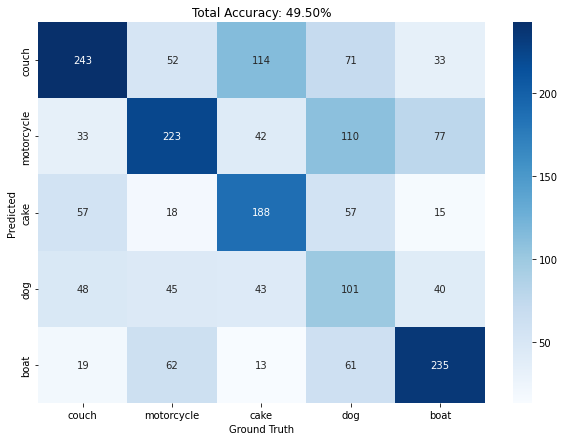

In [31]:
# Train the model
trained_model, train_losses, train_accs, test_accs = training(epochs, optimizer, criterion, model, train_data_loader, test_data_loader, device)

# Generate and plot the confusion matrix for the trained model
confusion_matrix(trained_model, test_data_loader, device)


No handles with labels found to put in legend.


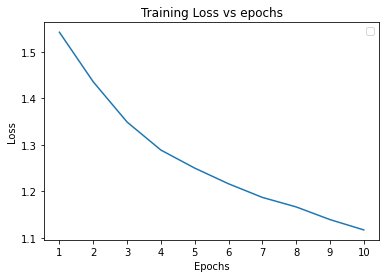

In [35]:
epochs = np.arange(1,11)
plt.xticks(epochs, epochs)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs epochs")
plt.plot(epochs,train_losses)
plt.legend(loc = "upper right")

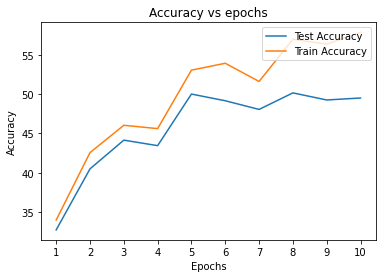

In [34]:
epochs = np.arange(1,11)
plt.xticks(epochs, epochs)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs epochs")
plt.plot(epochs,test_accs,label="Test Accuracy")
plt.plot(epochs,train_accs,label="Train Accuracy")
plt.legend(loc = "upper right")